# Классификация новостей с применением машинного обучения

## Понимание бизнес-целей

**Цель проекта** — разработать модель машинного обучения для автоматической классификации новостей по четырём темам:
*   World
*   Sports
*   Business
*   Science/Technology

**Задача:** Разработать модель машинного обучения для классификации новостных статей, основываясь на их текстовом содержании.

## Начальное изучение данных


*pandas, matpoltlib*



**Описание датасета:**

[AG News Classification Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) содержит:

120,000 статей для обучения.

7,600 статей для тестирования.

Каждая статья имеет заголовок и краткое описание, что делает его удобным для анализа.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

path = kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
train_path = path + "/train.csv"
test_path = path + "/test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

df = pd.concat([df_train, df_test], ignore_index=True)

print(df.head())

   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127600 entries, 0 to 127599
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  127600 non-null  int64 
 1   Title        127600 non-null  object
 2   Description  127600 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [ ]:
df['Class Index'].value_counts()

,count
Class Index,
3,31900
4,31900
2,31900
1,31900


In [ ]:
class_total_length = df.groupby('Class Index')['Description'].apply(lambda x: x.str.len().sum())

print(class_total_length)

Class Index
1    6245026
2    5903226
3    6336587
4    6184084
Name: Description, dtype: int64


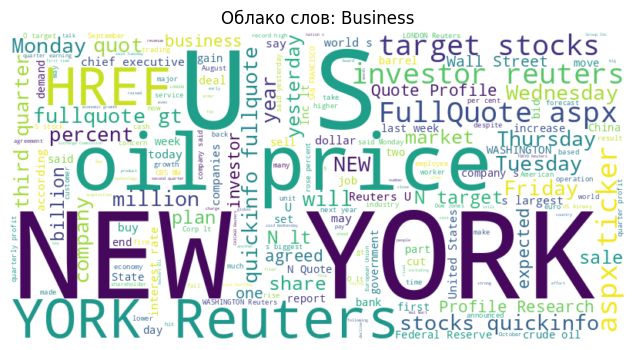

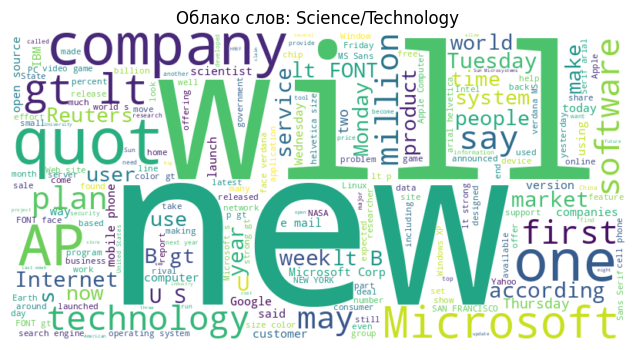

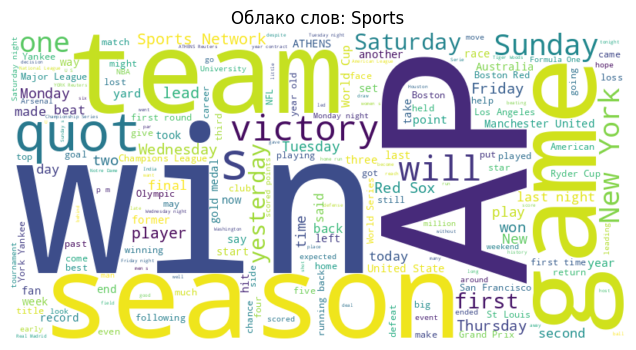

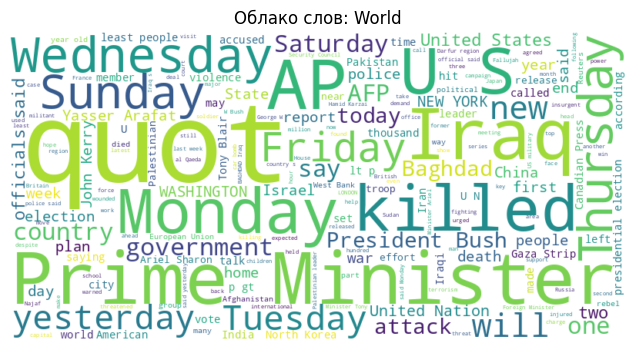

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

class_labels = {1: "World", 2: "Sports", 3: "Business", 4: "Science/Technology"}

for label in df['Class Index'].unique():
    text = " ".join(df[df['Class Index'] == label]['Description'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Облако слов: {class_labels[label]}')
    plt.show()

## Подготовка данных

*pandas, train_test_split из sklearn, WordNetLemmatizer, pos_tag из nltk*

**Шаги подготовки:**

Обработка данных:
* Перенести данные из столбца Title в Description, удалить столбец Title
* Очистить текст (привести к нижнему регистру, удалить html теги, цифры, пунктуацию, ссылки и стоп-слова).
* Лемматизация. При лемматизации текст подвергается более точной обработке, чем в ходе стемминга (в ходе тестирования было выявлено, что стемминг дает менее эффективные результаты)
* Удалить дубликаты

Подготовка данных для обучения моделей машинного обучения:

* Обучающая выборка: 80%.
* Тестовая выборка: 20%.

In [ ]:
df['Description'] = df['Title'] + ' ' + df['Description']

In [ ]:
df = df.drop(columns=['Title'])

In [ ]:
df['Description'] = df['Description'].str.lower()

In [ ]:
import re

def remove_html_tag(text):
    html = re.compile('<.*?>')
    cleaned_text = html.sub('', text)
    return cleaned_text

df['Description'] = df['Description'].apply(remove_html_tag)

In [ ]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text.strip()

df['Description'] = df['Description'].apply(clean_text)

In [ ]:
def url_remove(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

df['Description'] = df['Description'].apply(url_remove)

In [ ]:
custom_stopwords = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com']
stop_words = set(stopwords.words('english')).union(custom_stopwords)

df["Description"] = df['Description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [ ]:
# from nltk.stem import PorterStemmer
# porter_stemmer = PorterStemmer()

# def stemming(text):
#     tokens = text.split()
#     stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
#     return ' '.join(stemmed_tokens)

# df['Description'] = df['Description'].apply(stemming)

In [ ]:
lemmatizer = WordNetLemmatizer()

# Определение части речи для повышения точности
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatization(text):
    tokens = text.split()
    pos_tags = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags]
    return ' '.join(lemmatized_tokens)

df['Description'] = df['Description'].apply(lemmatization)


In [ ]:
df['Description'].value_counts()

,count
Description,
photo global gamers clash cash million prize money line gamers uzbekistan ecuador compete world cyber game,8
picture microsofts new medium center push software maker head la show host gadget use one another microsoft technology access movie music video,6
screenshot google desktop search tool google unveils first desktop application search personal file pc person web history,4
update pacificare buy american medical mln pacificare health system inc phsn quote profile research say wednesday agree buy american medical security group inc,3
u blast consistent nkorea explanation washington reuters north koreas explanation blast last week demolition work power project rather nuclear explosion square washington saw secretary state colin powell say tuesday,3
...,...
mush say situation india encourage manmohan sincere india news paris sept pakistan president pervez musharraf say ongoing peace process india encouraging,1
italian hostage iraq release doha september islamonlinenet amp news agency hostage crisis iraq saw breakthrough tuesday september two italian female hostage iraq release hour three others include egyptian also free,1
fifa discipline dope sanction ap ap soccer federation france italy netherlands discipline fifa cite lax drug infraction,1


In [ ]:
df = df.drop_duplicates(subset=['Description']).reset_index(drop=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Description'], df["Class Index"], test_size=0.2, random_state=42)

## Моделирование, Оценка, Внедрение

- Выбор, настройка и обучение модели машинного обучения для распознавания классификации текстов
- Оценка результатов моделирования

*TfidfVectorizer, Logistic Regression, classification_report, accuracy_score из sklearn*

**TF-IDF (Term Frequency-Inverse Document Frequency)** — это статистическая мера, используемая для **оценки важности слова в контексте документа или набора документов**. TF-IDF позволяет преобразовывать тексты в численные векторы, что позволяет использовать текстовые данные в моделях машинного обучения.

TF-IDF помогает выделить ключевые слова и фразы, которые наиболее важны для конкретного документа, что делает его незаменимым инструментом для таких задач, как ранжирование документов в поисковых системах, автоматическая аннотация текстов и **тематическая классификация**.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
vectorizer = TfidfVectorizer()
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

**Наивный Байес** и **логистическая регрессия** — это два распространенных метода классификации, которые имеют свои уникальные особенности, преимущества и недостатки.

**Наивный Байес:** Подходит для быстро обрабатываемых задач, особенно когда важна классификация текстовых данных. Преимущества включают скорость обработки и простоту, но ограничен предположениями о независимости признаков.

**Логистическая регрессия:** Идеальна для задач, требующих высокой интерпретируемости и анализа взаимосвязей между признаками. Может быть менее быстрой в обучении, но более гибкой в плане обработки данных.

Для модели был выбран алогритм **логистической регрессии**, так как он подходит для многоклассовой классификации, кроме того дает более высокую точность.

In [ ]:
model = LogisticRegression(max_iter=1000)

model.fit(X_train_vector, y_train)
y_pred = model.predict(X_test_vector)

print(f"Точность: {accuracy_score(y_test, y_pred):.2f}")
print("Отчет о классификации:\n", classification_report(y_test, y_pred))

Точность: 0.92
Отчет о классификации:
               precision    recall  f1-score   support

           1       0.93      0.90      0.92      6448
           2       0.96      0.98      0.97      6312
           3       0.89      0.89      0.89      6357
           4       0.89      0.90      0.89      6297

    accuracy                           0.92     25414
   macro avg       0.92      0.92      0.92     25414
weighted avg       0.92      0.92      0.92     25414



Общая точность модели составляет **92%**, что свидетельствует о высоком уровне правильных предсказаний по всем классам.

Для 3 и 4 классов показатели немного ниже, что может указывать на некоторые трудности модели в правильной идентификации этого класса. Это может быть связано с меньшим количеством примеров для этих классов в выборке.

### Примеры

In [ ]:
test_samples = [
    ("Florida’s star president, Ben Sasse, was among the best paid university presidents ever. He promised a conservative overhaul, but then he resigned, leaving controversy and an embarrassing drop in the U.S. News rankings.", 1),
    ("Karolyi trained multiple Olympic gold medalists and help turn the US into an international gymnastics power", 2),
    ("Postelection stock market thrust unable to be sustained as rate and valuation worries creep back in.", 3),
    ("Nvidia's (NVDA.O), opens new tab new Blackwell AI chips, which have already faced delays, have encountered problems with accompanying servers that overheat, causing some customers to worry they will not have enough time to get new data centers up and running, the Information reported on Sunday.", 4),
    ("Global response to climate change continues to evolve.", 1),
    ("The local football team won the championship game.", 2),
    ("Stock prices surge as economy continues to recover.", 3),
    ("Scientists discover new species of bacteria in Antarctica.", 4),
    ("Humanitarian aid efforts are underway in war-torn regions.", 1),
    ("Athletes break world records in thrilling races.", 2),
    ("Investors show confidence in the renewable energy market.", 3),
    ("Technological innovations in AI are advancing rapidly.", 4)
]

processed_samples = [sample[0] for sample in test_samples]
sample_vectors = vectorizer.transform(processed_samples)

sample_predictions = model.predict(sample_vectors)

for (sample_text, true_class), prediction in zip(test_samples, sample_predictions):
    print(f'Текст: "{sample_text}" \nИстинный класс: {true_class}, Предсказанный класс: {prediction}\n')

Текст: "Florida’s star president, Ben Sasse, was among the best paid university presidents ever. He promised a conservative overhaul, but then he resigned, leaving controversy and an embarrassing drop in the U.S. News rankings." 
Истинный класс: 1, Предсказанный класс: 1

Текст: "Karolyi trained multiple Olympic gold medalists and help turn the US into an international gymnastics power" 
Истинный класс: 2, Предсказанный класс: 2

Текст: "Postelection stock market thrust unable to be sustained as rate and valuation worries creep back in." 
Истинный класс: 3, Предсказанный класс: 3

Текст: "Nvidia's (NVDA.O), opens new tab new Blackwell AI chips, which have already faced delays, have encountered problems with accompanying servers that overheat, causing some customers to worry they will not have enough time to get new data centers up and running, the Information reported on Sunday." 
Истинный класс: 4, Предсказанный класс: 4

Текст: "Global response to climate change continues to evolve."

1: "World", 2: "Sports", 3: "Business", 4: "Science/Technology"